# scEU-seq: organoid kinetic analysis

This tutorial demonstrates single-cell kinetic analysis of intestine organoid data using {mod}`dynamo` with scEU-seq technology. We analyze the intestine organoid data from Battich, et al (2020), showing how {mod}`dynamo` can be used to perform kinetic analysis on scEU-seq datasets. This is the second tutorial in our scEU-seq series - please refer to the [cell cycle tutorial](https://dynamo-release.readthedocs.io/en/latest/scEU_seq_rpe1_analysis_kinetic.html) for details on analyzing cell cycle datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package umap-learn typing-extensions    tqdm statsmodels setuptools  \
version      0.5.7            4.13.2  4.67.1      0.14.4     79.0.0   

package session-info seaborn   scipy requests pynndescent pre-commit pandas  \
version        1.0.1  0.13.2  1.11.4   2.32.3      0.5.13      4.2.0  2.2.3   

package openpyxl numdifftools   numba networkx mudata matplotlib loompy  \
version    3.1.5       0.9.41  0.60.0    3.4.2  0.3.1     3.10.3  3.0.8   

package leidenalg  igraph dynamo-release colorcet anndata  
version    0.10.2  0.11.8       1.4.2rc1    3.1.0  0.11.4

## Load data

We load the scEU-seq organoid dataset using {func}`dynamo.sample_data.scEU_seq_organoid`.

In [2]:
organoid = dyn.sample_data.scEU_seq_organoid()

|-----> Downloading scEU_seq data
|-----> Downloading data to ./data/organoid.h5ad
|-----> in progress: 99.0108%|-----> [download] completed [72.9405s]


In [3]:
organoid

AnnData object with n_obs × n_vars = 3831 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time'
    var: 'ID', 'NAME'
    layers: 'sl', 'su', 'ul', 'uu'

In [4]:
# mapping:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

organoid.obs['cell_type'] = organoid.obs.som_cluster_id.map(cell_mapper).astype('str')


## Typical {mod}`dynamo` analysis workflow

We perform the standard preprocessing and analysis steps using {mod}`dynamo`'s comprehensive workflow.

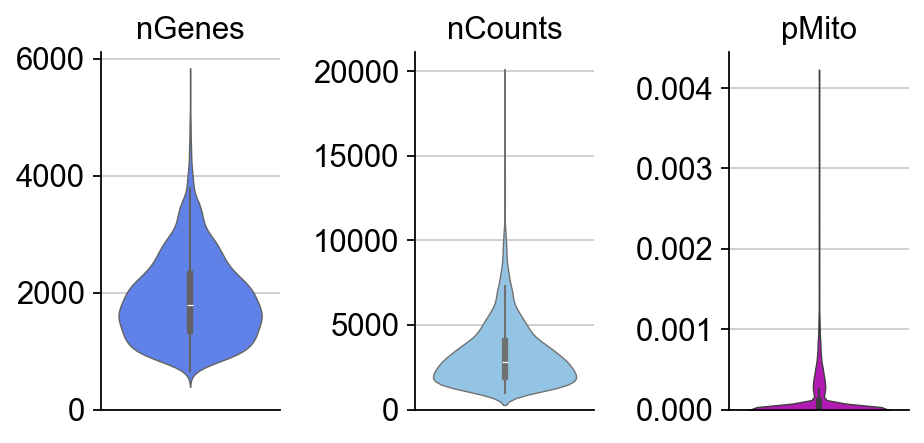

In [5]:
dyn.pl.basic_stats(organoid,figsize=(2,3))

In [6]:
organoid

AnnData object with n_obs × n_vars = 3831 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito'
    var: 'ID', 'NAME', 'nCells', 'nCounts'
    layers: 'sl', 'su', 'ul', 'uu'

In [8]:
organoid.obs.head()

well_id batch_id treatment_id      log10_gfp  rotated_umap1  \
1      14       01    Pulse_120  12.8929281522  23.0662174225   
2      15       01    Pulse_120  5.85486775252   25.710735321   
3      16       01    Pulse_120  7.45690471634  26.7709560394   
4      17       01    Pulse_120  94.2814535609  21.2927913666   
5      21       01    Pulse_120  47.1412266395  19.9096126556   

     rotated_umap2 som_cluster_id monocle_branch_id monocle_pseudotime  \
1   -3.47039175034              6                 2      6.08688834859   
2   -1.31835341454              2                 2      9.14740876358   
3   -1.06682777405              2                 2      9.69134627386   
4  0.0159659013152             11                 2       4.2635104705   
5   0.884054124355             11                 1      2.62248093423   

  exp_type time    cell_type  nGenes  nCounts  pMito  
1    Pulse  120     TA cells    1054   1426.0    0.0  
2    Pulse  120  Enterocytes    1900   3712.0    0.0  
3    Pulse  120  Enterocytes    2547   6969.0    0.0  
4    Pulse  120   Stem cells    1004   1263.0    0.0  
5    Pulse  120   Stem cells     927   1144.0    0.0

In [9]:
organoid.obs.groupby(['exp_type', 'time']).agg('count')

well_id  batch_id  treatment_id  log10_gfp  rotated_umap1  \
exp_type time                                                              
Chase    0         660       660           660        660            660   
         45        821       821           821        821            821   
         120         0         0             0          0              0   
         360       646       646           646        646            646   
         dmso        0         0             0          0              0   
Pulse    0           0         0             0          0              0   
         45          0         0             0          0              0   
         120      1373      1373          1373       1373           1373   
         360         0         0             0          0              0   
         dmso      331       331           331        331            331   

               rotated_umap2  som_cluster_id  monocle_branch_id  \
exp_type time                                                     
Chase    0               660             660                660   
         45              821             821                821   
         120               0               0                  0   
         360             646             646                646   
         dmso              0               0                  0   
Pulse    0                 0               0                  0   
         45                0               0                  0   
         120            1373            1373               1373   
         360               0               0                  0   
         dmso            331             331                331   

               monocle_pseudotime  cell_type  nGenes  nCounts  pMito  
exp_type time                                                         
Chase    0                    660        660     660      660    660  
         45                   821        821     821      821    821  
         120                    0          0       0        0      0  
         360                  646        646     646      646    646  
         dmso                   0          0       0        0      0  
Pulse    0                      0          0       0        0      0  
         45                     0          0       0        0      0  
         120                 1373       1373    1373     1373   1373  
         360                    0          0       0        0      0  
         dmso                 331        331     331      331    331

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
When analyzing labeling based scRNA-seq without providing `tkey`, dynamo will try to use 
 `time` as the key for labeling time. Please correct this via supplying the correct `tkey`
if needed.
|-----> detected experiment type: one-shot
|-----? Looks like you are using minutes as the time unit.

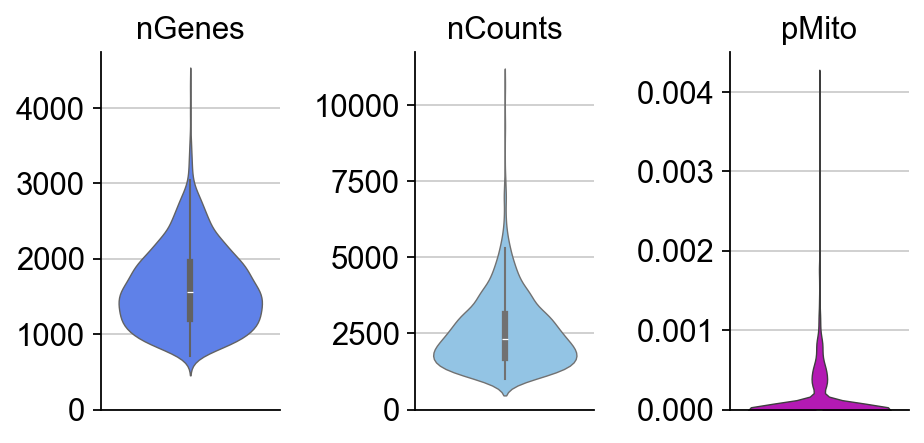

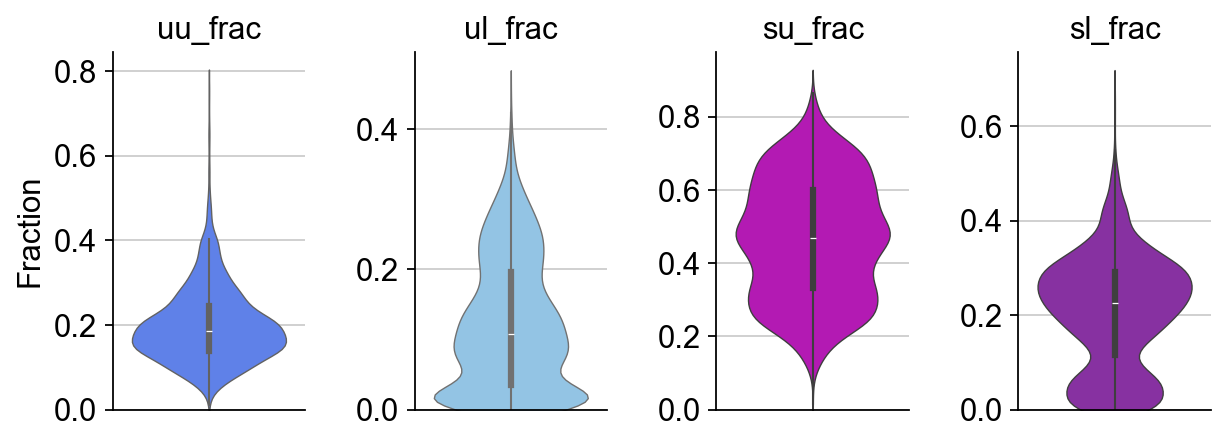

In [10]:
adata = organoid.copy()
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]
adata.layers['new'], adata.layers['total'] = adata.layers['ul'] + adata.layers['sl'], adata.layers['su'] + adata.layers['sl'] + adata.layers['uu'] + adata.layers['ul']
del adata.layers['uu'], adata.layers['ul'], adata.layers['su'], adata.layers['sl']
dyn.pp.recipe_monocle(adata, n_top_genes=1000, total_layers=False)
# preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
# preprocessor.config_monocle_recipe(adata, n_top_genes=1000)                                  
# preprocessor.preprocess_adata_monocle(adata)
dyn.pl.basic_stats(adata,figsize=(2,3))
dyn.pl.show_fraction(organoid,figsize=(2,3))

In [11]:
adata.obs.time = adata.obs.time/60

In [12]:
adata.obs.time  = adata.obs.time.astype('float')
dyn.tl.dynamics(adata, model='deterministic', tkey='time', assumption_mRNA='ss')
dyn.tl.reduceDimension(adata)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [13.7746s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|██████████| 1000/1000 [00:13<00:00, 72.92it/s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [10.1453s]


In [13]:
dyn.tl.cell_velocities(adata, ekey='M_t', vkey='velocity_T', enforce=True)

|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [3.9081s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.4533s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'cell_cycle_scores', 'X_umap', 'velocity_umap'
    varm: 'alpha', 'vel_params'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt'

In [14]:
adata.obsm['X_umap_ori'] = adata.obs.loc[:, ['rotated_umap1', 'rotated_umap2']].values.astype(float)

## Visualize time-resolved vector flow learned with {mod}`dynamo`

We use {func}`dynamo.pl.streamline_plot` to visualize the learned vector field and cellular dynamics.

Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.4446s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_ori
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


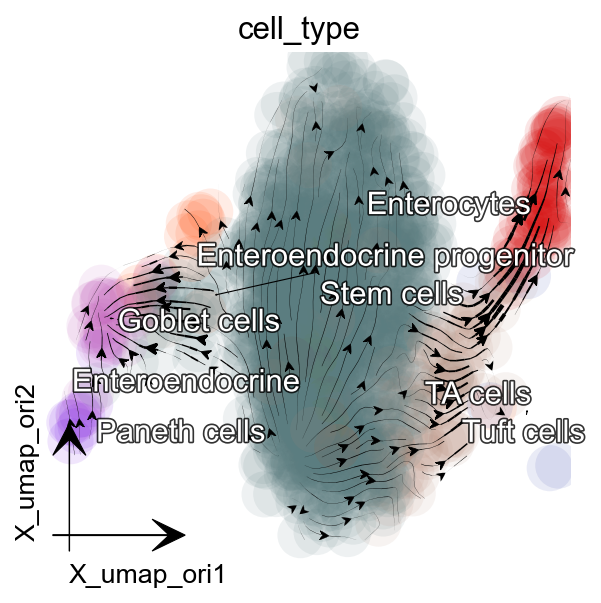

In [16]:
dyn.tl.cell_velocities(adata, basis='umap_ori')

dyn.pl.streamline_plot(adata, color='cell_type', 
                       basis='umap_ori',figsize=(4,4),
                       s_kwargs_dict={'adjust_legend':True},
                      )


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_ori
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


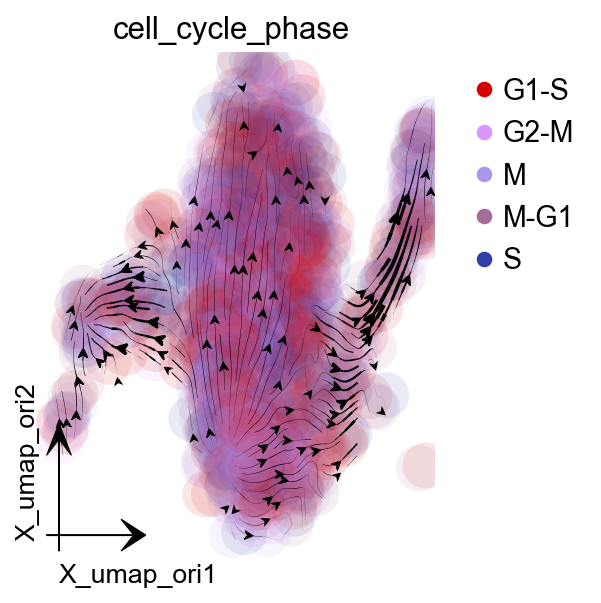

In [20]:
dyn.pl.streamline_plot(adata, color='cell_cycle_phase', 
                       basis='umap_ori',figsize=(4,4),
                       show_legend='upper right',
                       s_kwargs_dict={'adjust_legend':True},
)


In [21]:
adata.var_names[adata.var.use_for_transition][:5]

Index(['Cdc45', 'Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb'], dtype='object')

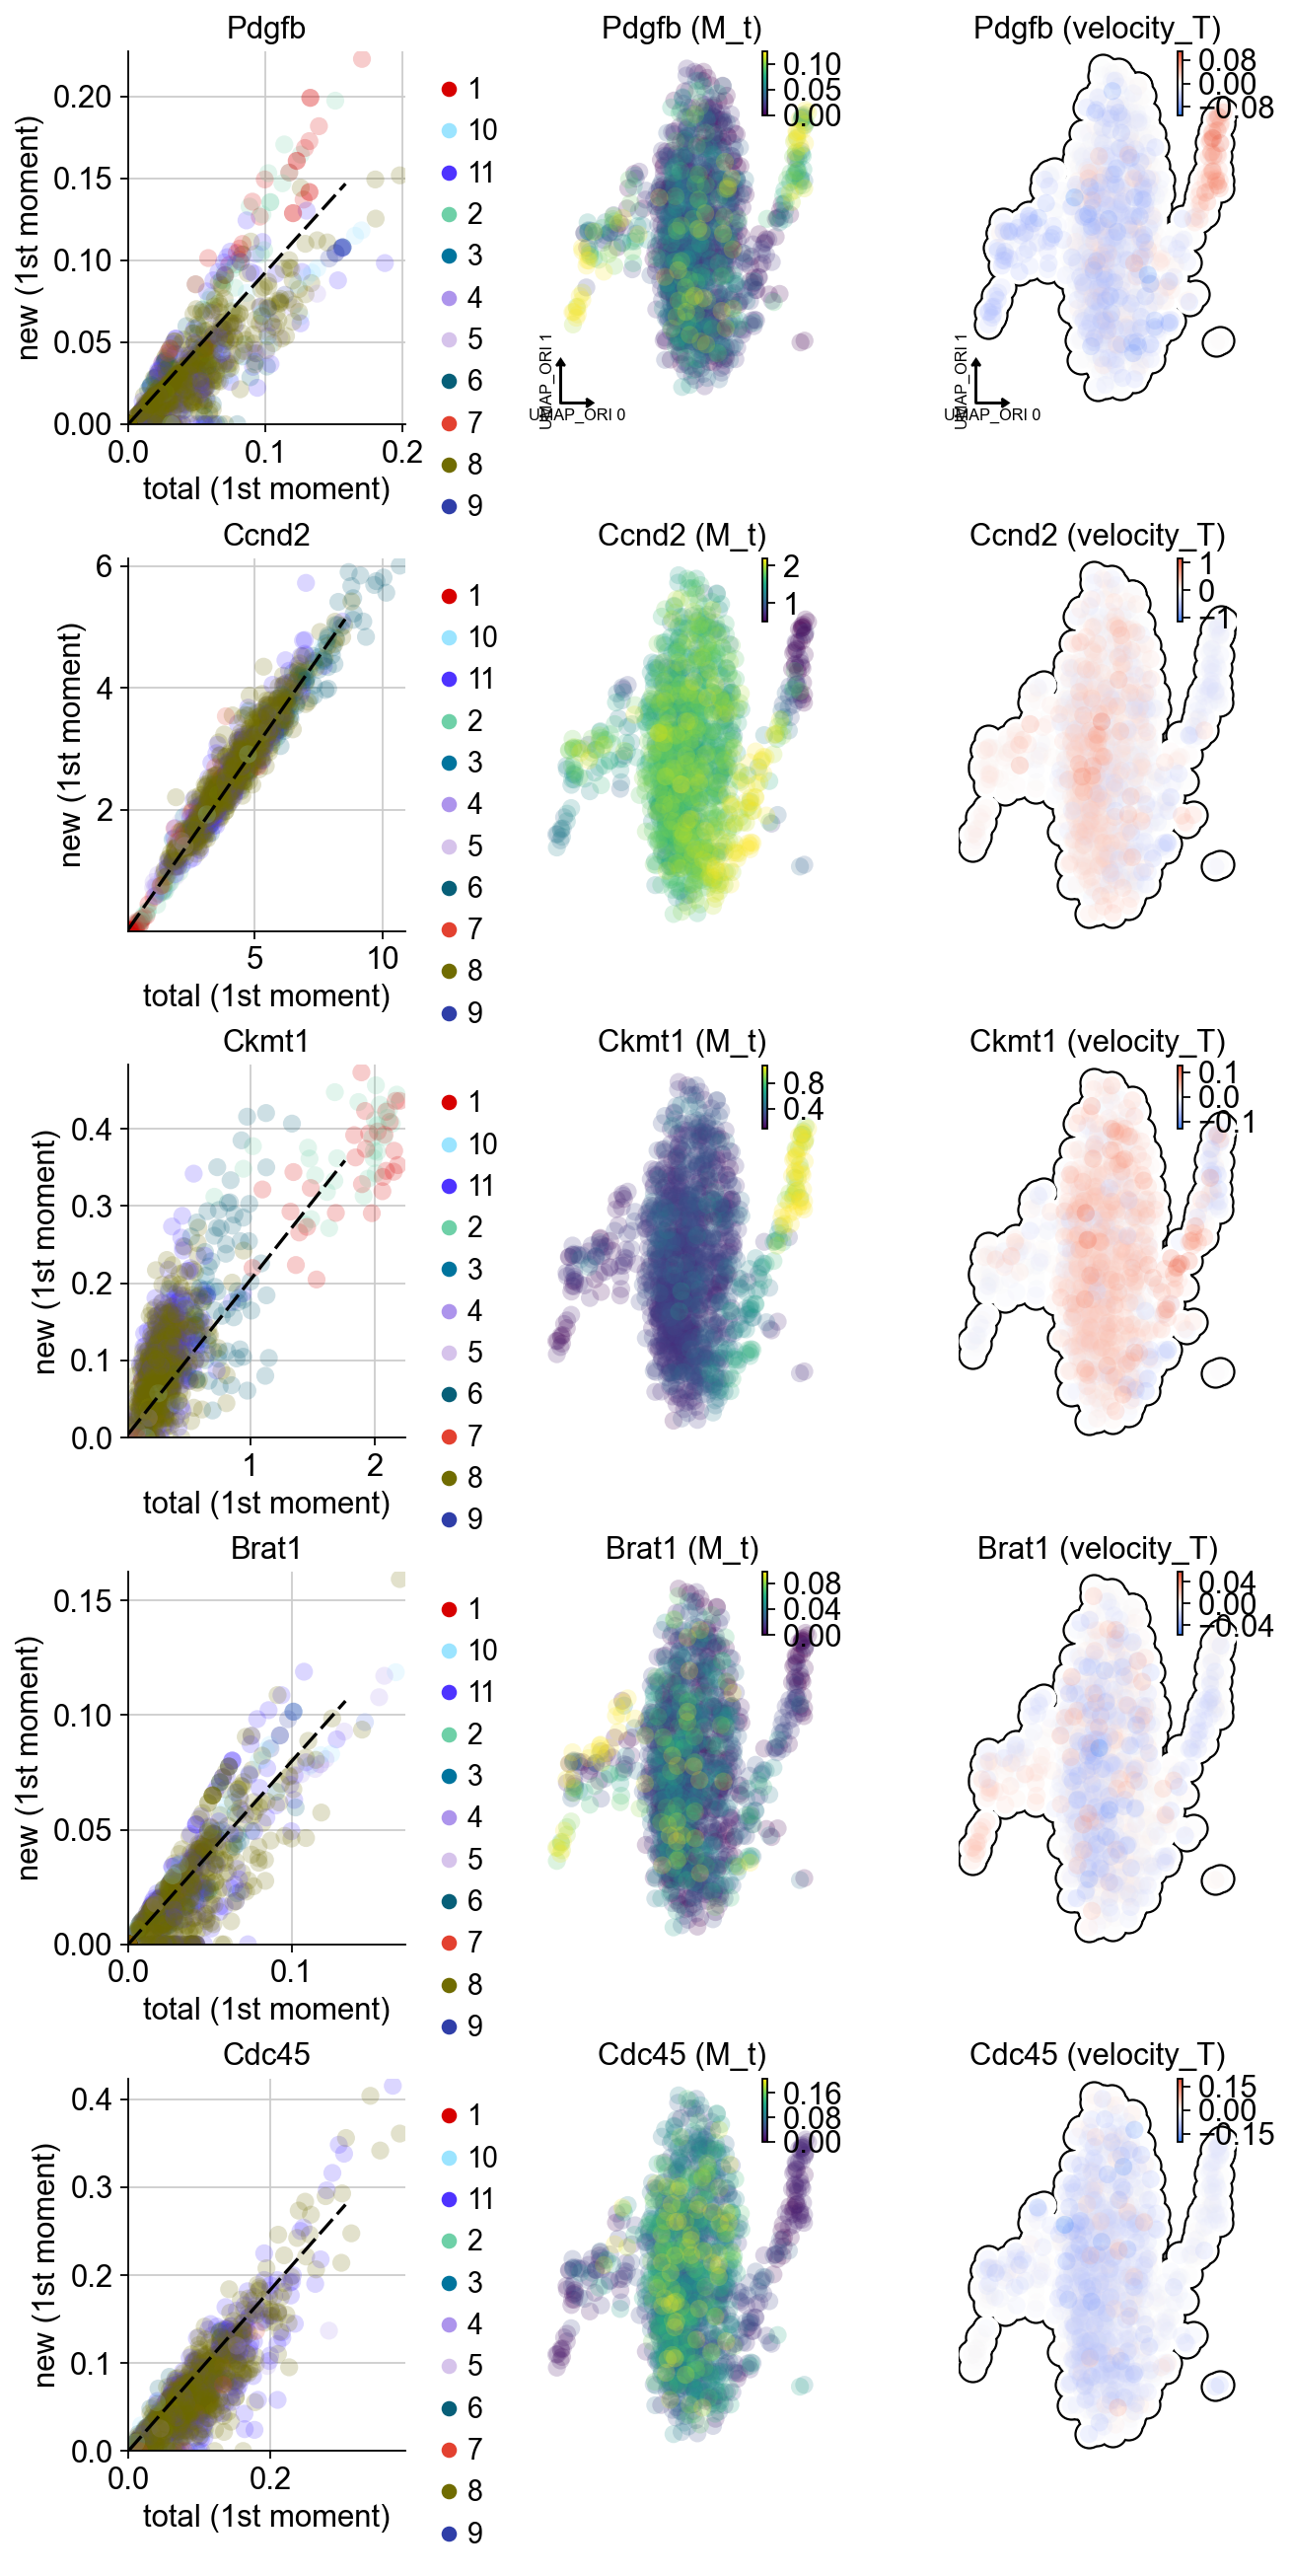

In [23]:
dyn.pl.phase_portraits(adata, genes=['Cdc45', 'Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb'],
                       color='som_cluster_id', basis='umap_ori',figsize=(3,4))

## Animate intestine organoid differentiation

We use {func}`dynamo.pd.fate` and {mod}`dynamo.mv` animation capabilities to visualize organoid differentiation dynamics over time.

In [24]:
dyn.vf.VectorField(adata, basis='umap_ori')

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP_ORI. 
        Vector field will be learned in the UMAP_ORI space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [1.1309s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [1.4815s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 2-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-

In [25]:
progenitor = adata.obs_names[adata.obs.cell_type == 'Stem cells']
len(progenitor)

1146

In [30]:
from matplotlib import animation
info_genes = adata.var_names[adata.var.use_for_transition]
dyn.pd.fate(adata, basis='umap_ori', init_cells=progenitor[:100], 
            interpolation_num=100,  direction='forward',
   inverse_transform=False, average=False)


uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 441.83it/s]


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_umap_ori', 'cell_type_colors', 'cell_cycle_phase_colors', 'VecFld_umap_or

|-----------> plotting with basis key=X_umap_ori
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


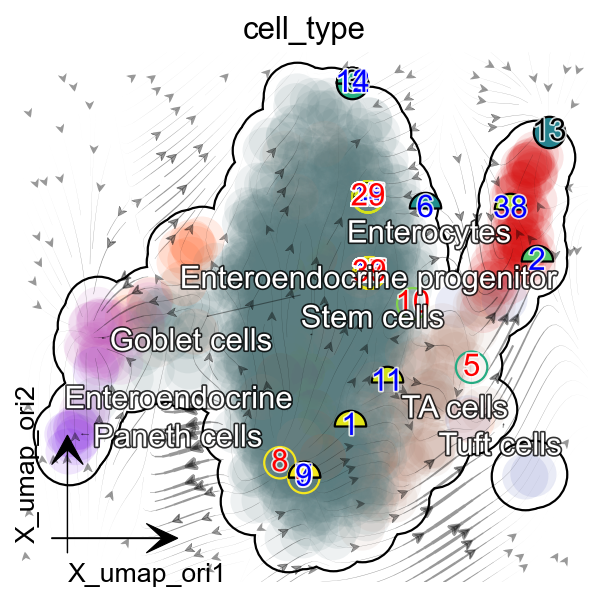

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
dyn.pl.topography(adata, basis='umap_ori', background='white', 
                  color=['cell_type'], fps_basis='umap_ori',
                  streamline_color='black', s_kwargs_dict={'adjust_legend':True},
                  show_legend='on data', frontier=True,ax=ax)
ax.set_aspect(0.8)

In [32]:
%%capture
adata.obs['time'] = adata.obs.time.astype('float')
instance = dyn.mv.StreamFuncAnim(adata=adata, basis='umap_ori', 
                                 color='cell_type', ax=ax,fig=fig,)

|-----? the number of cell states with fate prediction is more than 50. You may want to lower the max number of cell states to draw via cell_states argument.


In [33]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**64 # Ensure all frames will be embedded.

from matplotlib import animation
import numpy as np

anim = animation.FuncAnimation(instance.fig, instance.update, init_func=instance.init_background,
                               frames=np.arange(20), interval=20, blit=True)
from IPython.core.display import display, HTML
HTML(anim.to_jshtml()) # embedding to jupyter notebook.